### Распаковка датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/dataset.zip'
destination_folder = '/content/dataset_unzipped'

import os
os.makedirs(destination_folder, exist_ok=True)

import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Файл {zip_file_path} успешно распакован в {destination_folder}")

Файл /content/drive/MyDrive/dataset.zip успешно распакован в /content/dataset_unzipped


### Создание кастомного датасета для загрузки изображений


In [ ]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = []
        self.labels = []
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        self.image_files.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')

        return img, label

### Инициализация датасета и базовая проверка корректности


In [ ]:
dataset_root_dir = '/content/dataset_unzipped/dataset'

try:
    image_dataset = ImageDataset(root_dir=dataset_root_dir)
    print(f"Датасет успешно инициализирован. Найдено {len(image_dataset)} изображений в {len(image_dataset.classes)} классах.")
    print(f"Классы: {image_dataset.classes}")
except Exception as e:
    print(f"Произошла ошибка при инициализации датасета: {e}")

Датасет успешно инициализирован. Найдено 2400 изображений в 24 классах.
Классы: ['BEL', 'BGR', 'BLR', 'CAN', 'CHL', 'DEU', 'DOM', 'ESP', 'EST', 'GBR', 'HUN', 'IDN', 'IRL', 'ITA', 'KAZ', 'KGZ', 'MDA', 'MEX', 'NLD', 'POL', 'SVK', 'SWE', 'USA', 'UZB']


### Визуализация случайных примеров из датасета


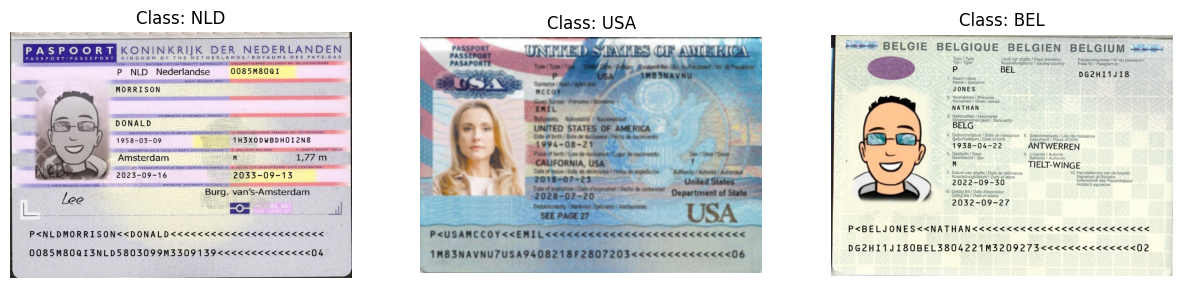

In [ ]:
import random
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(image_dataset)), 3)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    img, label = image_dataset[idx]
    class_name = image_dataset.classes[label]

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

### Примеры для одной из стран


Изображения для класса 'GBR' (индекс: 9) будут отображены.


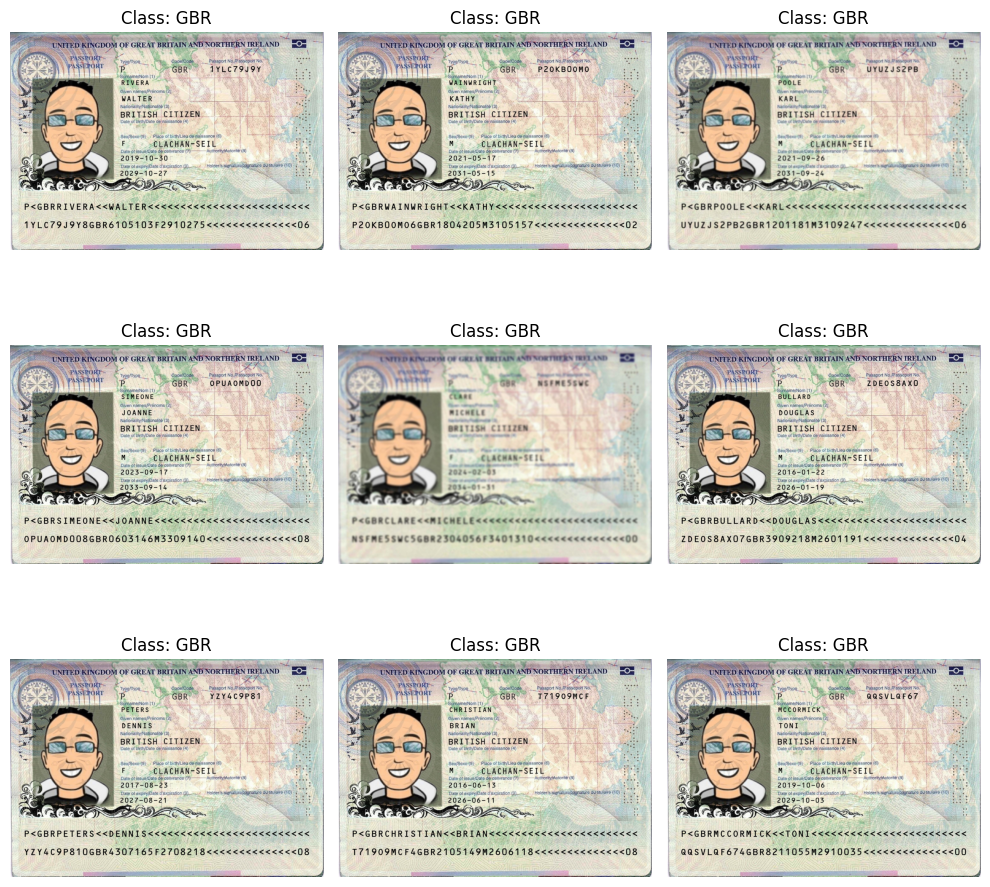

In [ ]:
import random
import matplotlib.pyplot as plt

target_class_name = 'GBR'

try:
    target_class_index = image_dataset.classes.index(target_class_name)
    print(f"Изображения для класса '{target_class_name}' (индекс: {target_class_index}) будут отображены.")
except ValueError:
    print(f"Класс '{target_class_name}' не найден в датасете. Доступные классы: {image_dataset.classes}")
    target_class_index = None

if target_class_index is not None:
    class_indices = [i for i, label in enumerate(image_dataset.labels) if label == target_class_index]

    if len(class_indices) < 9:
        print(f"В классе '{target_class_name}' найдено только {len(class_indices)} изображений. Отобразим все доступные изображения.")
        display_indices = class_indices
    else:
        display_indices = random.sample(class_indices, 9)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(display_indices):
        img, label = image_dataset[idx]
        class_name = image_dataset.classes[label]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Отличительные черты каждого класса/страны:
- Визуальный вид (фон, оформление)
- Текст (есть чёткий опознавательный текст: чаще всего сверху пишется названия страны, поле кода страны, поле MRZ + язык в качестве дополнительный фичи, если пригодится, хотя бы разделить группы стран)

Нужно выбрать самые надёжные и информативные поля


Доп. замечания:
- Качество картинок различается (upscale?), можно использовать blur в качестве аугментации для имитации этой сложности
- Датасет крайне чистый, надо учитывать, что некоторые методы, которые работают конкретно на этих данных, могут быть плохи на других (где будут затеменения от фотографий, если это не сканы, повороты на n градусов и тп), иожет быть аугментации сымитирует реальные сложности


MRZ — Machine Readable Zone кажется самым надёжным, ибо располагается в конкретном месте и имеет конкретный паттерн заполнения

Нагуглил такое:
- Первая строка: P<COUNTRYSURNAME<<GIVEN<NAMES<<<<<<<<<<<<<<<<<<<<
- Вторая строка: PASSPORT#CHECKCOUNTRYBIRTHDATECHECKSEXEXPDATECHECKNATIONALITY<<<<<

Также нужно продумать кейс, когда не читается MRZ и надо всё равно провести классификацию


Сначала хочется создать бэйзлайн модель (наивная vision модель на классы). Дальше уже можно проверить несколько гипотез, понимая динамику относительно бэйзлайга

До этого проведём базовое EDA, но вроде кажется что 24 класса по 100 изображений

### Проверка распределения количества примеров по классам


Количество изображений в каждом классе:
Класс 'BEL': 100 изображений
Класс 'BGR': 100 изображений
Класс 'BLR': 100 изображений
Класс 'CAN': 100 изображений
Класс 'CHL': 100 изображений
Класс 'DEU': 100 изображений
Класс 'DOM': 100 изображений
Класс 'ESP': 100 изображений
Класс 'EST': 100 изображений
Класс 'GBR': 100 изображений
Класс 'HUN': 100 изображений
Класс 'IDN': 100 изображений
Класс 'IRL': 100 изображений
Класс 'ITA': 100 изображений
Класс 'KAZ': 100 изображений
Класс 'KGZ': 100 изображений
Класс 'MDA': 100 изображений
Класс 'MEX': 100 изображений
Класс 'NLD': 100 изображений
Класс 'POL': 100 изображений
Класс 'SVK': 100 изображений
Класс 'SWE': 100 изображений
Класс 'USA': 100 изображений
Класс 'UZB': 100 изображений


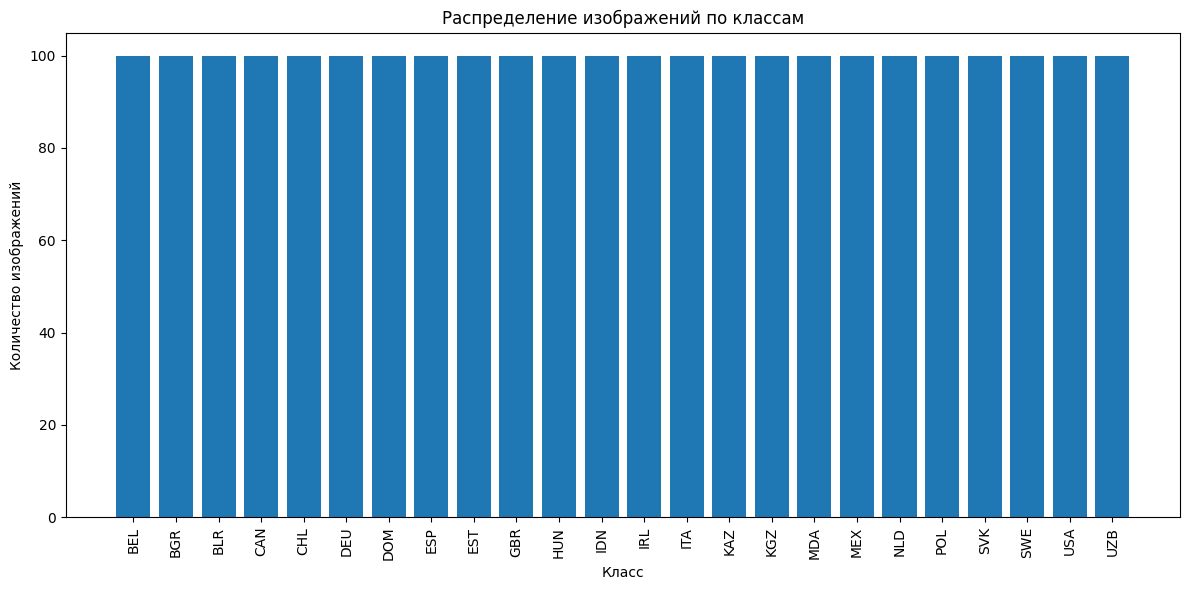

In [ ]:
from collections import Counter

all_labels = image_dataset.labels
label_counts = Counter(all_labels)

print("Количество изображений в каждом классе:")
for label_index, count in label_counts.items():
    class_name = image_dataset.classes[label_index]
    print(f"Класс '{class_name}': {count} изображений")

import matplotlib.pyplot as plt

class_names = [image_dataset.classes[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(class_names, counts)
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Распределение классов равномерное, но на каждый класс немного изображений, есть риск переобучения

### Сплит на train/val


In [ ]:
from sklearn.model_selection import train_test_split

image_paths = image_dataset.image_files
labels = image_dataset.labels

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42, stratify=labels
)

print(f"Размер обучающей выборки: {len(train_paths)} изображений")
print(f"Размер валидационной выборки: {len(val_paths)} изображений")

from collections import Counter

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)

print("\nРаспределение классов в обучающей выборке:")
for label_index, count in sorted(train_label_counts.items()):
    class_name = image_dataset.classes[label_index]
    print(f"Класс '{class_name}': {count} изображений")

print("\nРаспределение классов в валидационной выборке:")
for label_index, count in sorted(val_label_counts.items()):
    class_name = image_dataset.classes[label_index]
    print(f"Класс '{class_name}': {count} изображений")

Размер обучающей выборки: 2160 изображений
Размер валидационной выборки: 240 изображений

Распределение классов в обучающей выборке:
Класс 'BEL': 90 изображений
Класс 'BGR': 90 изображений
Класс 'BLR': 90 изображений
Класс 'CAN': 90 изображений
Класс 'CHL': 90 изображений
Класс 'DEU': 90 изображений
Класс 'DOM': 90 изображений
Класс 'ESP': 90 изображений
Класс 'EST': 90 изображений
Класс 'GBR': 90 изображений
Класс 'HUN': 90 изображений
Класс 'IDN': 90 изображений
Класс 'IRL': 90 изображений
Класс 'ITA': 90 изображений
Класс 'KAZ': 90 изображений
Класс 'KGZ': 90 изображений
Класс 'MDA': 90 изображений
Класс 'MEX': 90 изображений
Класс 'NLD': 90 изображений
Класс 'POL': 90 изображений
Класс 'SVK': 90 изображений
Класс 'SWE': 90 изображений
Класс 'USA': 90 изображений
Класс 'UZB': 90 изображений

Распределение классов в валидационной выборке:
Класс 'BEL': 10 изображений
Класс 'BGR': 10 изображений
Класс 'BLR': 10 изображений
Класс 'CAN': 10 изображений
Класс 'CHL': 10 изображений
Класс '

### Модель: ResNet18 с заменой финального слоя


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

num_classes = len(image_dataset.classes)
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

ImageDataset хорошо подходит для базового просмотра данных и EDA, так как она просто загружает изображения и метки.

CustomImageDataset вместе с DataLoader более подходит для обучения моделей глубокого обучения

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import os

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomImageDataset(train_paths, train_labels, transform=train_transform)
val_dataset = CustomImageDataset(val_paths, val_labels, transform=val_transform)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training dataloader created with batch size {batch_size}")
print(f"Validation dataloader created with batch size {batch_size}")


Training dataset size: 2160
Validation dataset size: 240
Training dataloader created with batch size 32
Validation dataloader created with batch size 32


### Обучение модели — train loop


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)

    return epoch_loss, accuracy

In [ ]:
num_epochs = 10
best_val_accuracy = 0.0
best_model_wts = model.state_dict()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    train_loss = train_model(model, train_dataloader, criterion, optimizer, device)
    print(f'Training Loss: {train_loss:.4f}')

    val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    print()

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_wts = model.state_dict()
        print(f'Validation accuracy improved. Saving model weights.')
        torch.save(model.state_dict(), 'best_resnet18.pth')

    if val_acc >= 1.0:
        print("Validation accuracy reached 1.0. Stopping training.")
        break

model.load_state_dict(best_model_wts)
print("Loaded best model weights based on validation accuracy.")

Epoch 1/10
----------


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Training Loss: 1.8823


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.6115 Acc: 1.0000

Validation accuracy improved. Saving model weights.
Validation accuracy reached 1.0. Stopping training.
Loaded best model weights based on validation accuracy.


Очевидный минус подхода с мультиклассовой классификацией классических vision-моделей: они не обобщаются на новые классы, для этого требуется дообучение, но что важнее - достаточное количество данных по каждому классу, что при применении в жизни модель будет лажать с редкими (малонаселённые страны или просто неповезло не иметь данных по этой стране) паспортами, да и вообще с любыми новыми

Очень условно: есть идея комбинированного подхода, в большинстве случаев такой vision-модели будет хватать (хотя кажется что примеры а датасете слишком простые), можно иметь некоторый список "популярных" стран, на которых была обучена vision-модель и использовать её для разных целей:
- Первоначальная классификация. Если плохая уверенность -> кормим изображение другим моделям
- Подтверждение выбора страны. Если первоначальное определение показало одну из "популярных" стран, то прогоняем через vision-модель, работает как дополнительный верификатор, если идёт несовпадение, то либо ещё модель какая-то, либо ручной верификатор (если есть такая возможность у сервиса и он не нарушает никаких требований), либо просим переделать фотографию/скан документов
- Использовать как альтернативу, если не работают другие методы (закрыт MRZ, код страны и тп)


In [ ]:
!pip install paddleocr

In [ ]:
!pip install paddlepaddle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: opt_einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0


In [ ]:
from paddleocr import PaddleOCR
ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False)

result = ocr.predict(
    input="/content/dataset_unzipped/dataset/BEL/BEL_0.jpg")

for res in result:
    res.print()
    res.save_to_img("output")
    res.save_to_json("output")


/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:715: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or da

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/87.9M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/903 [00:00<?, ?B/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/84.4M [00:00<?, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

{'res': {'input_path': '/content/dataset_unzipped/dataset/BEL/BEL_0.jpg', 'page_index': None, 'model_settings': {'use_doc_preprocessor': True, 'use_textline_orientation': False}, 'doc_preprocessor_res': {'input_path': None, 'page_index': None, 'model_settings': {'use_doc_orientation_classify': False, 'use_doc_unwarping': False}, 'angle': -1}, 'dt_polys': array([[[ 291,   38],
        ...,
        [ 291,   94]],

       ...,

       [[1211, 1284],
        ...,
        [1211, 1310]]], dtype=int16), 'text_det_params': {'limit_side_len': 64, 'limit_type': 'min', 'thresh': 0.3, 'max_side_limit': 4000, 'box_thresh': 0.6, 'unclip_ratio': 1.5}, 'text_type': 'general', 'textline_orientation_angles': array([-1, ..., -1]), 'text_rec_score_thresh': 0.0, 'rec_texts': ['BELGIE', 'BELGIQUE', 'BELGIEN', 'BELGIUM', '福', 'Type/Type', 'Landvan afgifte/Pays emelleur', 'Paspoortnummer/Ndu passeport', 'Typ/Type', 'Ausstellungslandflssuing country', 'Pass-Nr/Passport no', 'P', 'BEL', '0XCS6N4RP', 'Naam/Nom',

In [ ]:
inp = "/content/dataset_unzipped/dataset/DEU/D_5.jpg"
result = ocr.predict(input=inp)

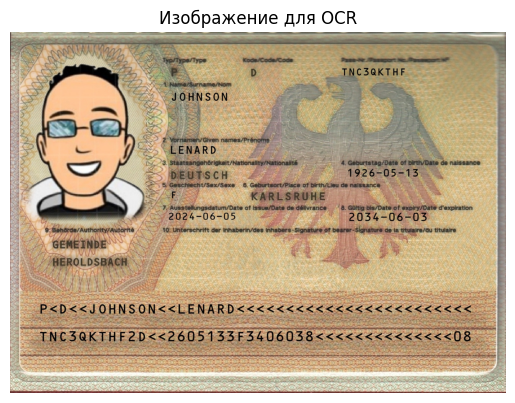

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_to_display = Image.open(inp)

plt.imshow(img_to_display)
plt.title("Изображение для OCR")
plt.axis('off')
plt.show()

### Пример инференса OCR на одном изображении


In [ ]:
for res in result:
    for text in res.json['res']['rec_texts']:
        print(text, detect_language(text))


Typ/Type/Type no
Kode/Coda/Code pt
P tl
TNC3QKTHF vi
1Name/Surname/Nom en
JOHNSON id
Vornamen/Given names/Prenoms sv
LENARD fr
3.Staatsangehorigkeit/Natlanallty/Nationalite de
4.Geburtstag/Date of birth/Date de naissance de
DEUTSCH de
1926-05-13 unknown
5.Geschlecht/Sex/Sexe6.Geburteort/Place of birth/Lieu de naissance de
F de
KARLSRUHE sw
7.Ausstollungsdatum/Date of issue/Date de delivrance de
8.Gultig bis/Date of expiry/Date dexpiration en
2024-06-05 unknown
2034-06-03 unknown
9.Bohorde/Authority/Autorite en
10.Unterschrift der Inhaberin/des Inhabers-Signature of bearer-Slgnature de la titulaire/du titulalre de
GEMEINDE de
小 ko
HEROLDSBACH vi
P<D<<JOHNSON<<LENARD<<<<<<<<<<<<<<<<<<<<<> de
TNC3QKTHF2D<<2605133F3406038<<<<<<<<<<<<<<08 de


Вообще есть координаты каждого текста и можно было бы распарсить какой текст к какому полю относиться, но сейчас кажется это излишне

Имея теперь текст, можно выделить какие-то сигналы, связанные с ним, которые классифицируют страну, такие сигналы бывают разные:
- Жёсткие, которые гарантируют наличие этой страны: MRZ, Явное упоминание страны на английском (если не английский, то мы имеем достаточно много языков, на которых надо было бы проверять название, хотя в теории можно собрать или где-то уже есть универсальные решения), e.g. BELGIUM. С этими критериями более понятно как работать
- Сильные, но неточные: язык (часто не говорит о конкретной стране), адреса/названия регионов/городов (непонятно как соотносить каждый город со страной)


In [ ]:
!pip -q install pycountry country_converter Babel rapidfuzz Unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 20.1 MB/s eta 0:00:00


In [ ]:
!pip install langdetect

In [ ]:
from langdetect import detect, DetectorFactory, LangDetectException


DetectorFactory.seed = 42

def detect_language(text: str) -> str:
    """Detects the language of the input text string."""
    try:
        lang_code = detect(text)
        return lang_code
    except LangDetectException:
        return "unknown"
    except Exception as e:
        print(f"An unexpected error occurred during language detection: {e}")
        return "unknown"

print(f"Language of 'This is a test sentence in English.' is: {detect_language('This is a test sentence in English.')}")
print(f"Language of 'Ceci est une phrase de test en français.' is: {detect_language('Ceci est une phrase de test en français.')}")
print(f"Language of 'Dies ist ein Testsatz in deutscher Sprache.' is: {detect_language('Dies ist ein Testsatz in deutscher Sprache.')}")
print(f"Language of 'Это тестовое предложение на русском языке.' is: {detect_language('Это тестовое предложение на русском языке.')}")
print(f"Language of 'P<BELCAPP<<RAFAEL<<<<<<<<<<<<<<<<<<<<<<<<<<<' is: {detect_language('P<BELCAPP<<RAFAEL<<<<<<<<<<<<<<<<<<<<<<<<<<<')}") # Test with MRZ-like string
print(f"Language of 'BELGIE BELGIQUE BELGIEN BELGIUM' is: {detect_language('BELGIE BELGIQUE BELGIEN BELGIUM')}") # Test with country names
print(f"Language of '' is: {detect_language('')}") # Test with empty string
print(f"Language of 'a' is: {detect_language('a')}") # Test with short string

Language of 'This is a test sentence in English.' is: en
Language of 'Ceci est une phrase de test en français.' is: fr
Language of 'Dies ist ein Testsatz in deutscher Sprache.' is: de
Language of 'Это тестовое предложение на русском языке.' is: ru
Language of 'P<BELCAPP<<RAFAEL<<<<<<<<<<<<<<<<<<<<<<<<<<<' is: en
Language of 'BELGIE BELGIQUE BELGIEN BELGIUM' is: vi
Language of '' is: unknown
Language of 'a' is: tl


### Основная логика: парсинг текста, MRZ, ISO, alias стран и fallback


In [ ]:
import re
from typing import List, Dict, Tuple, Any
import pycountry
import country_converter as coco
from babel import Locale
from babel.core import UnknownLocaleError
from unidecode import unidecode
from rapidfuzz import process, fuzz

# ---------- Normalization ----------
def normalize(s: str) -> str:
    s = s.strip()
    s = s.replace("’", "'").replace("`", "'").replace("´", "'")
    s = re.sub(r"[^\w\s'-]", " ", s)
    s = re.sub(r"\s+", " ", s)
    s = s.lower()
    s = unidecode(s)
    return s.strip()

# ---------- Build multilingual aliases (offline) ----------
def build_country_alias_index(candidate_locales: List[str] = None) -> Dict[str, Any]:
    """
    Возвращает:
      {
        'ALIASES_BY_ISO3': {iso3: {'raw': [...], 'norm': [...]}},
        'ALIAS_TO_ISO3':   {normalized_alias: iso3},
        'ISO3_TO_ISO2':    {iso3: iso2},
        'ISO3_TO_NAME':    {iso3: canonical_english_name},
        'ALIAS_KEYS':      [normalized_alias, ...]  # список ключей для RapidFuzz
      }
    """
    if candidate_locales is None:
        candidate_locales = [
            "en","fr","de","es","it","pt","nl","da","sv","no","fi","pl",
            "cs","sk","sl","hu","ro","bg","el","tr","ru","uk","kk",
            "ar","he","fa","ur",
            "hi","bn","ta","te",
            "zh","zh_Hant","ja","ko","th","vi","id","ms"
        ]

    cc = coco.CountryConverter()
    ALIASES_BY_ISO3, ISO3_TO_ISO2, ISO3_TO_NAME = {}, {}, {}

    for c in pycountry.countries:
        iso2 = getattr(c, "alpha_2", None)
        iso3 = getattr(c, "alpha_3", None)
        if not iso2 or not iso3:
            continue

        ISO3_TO_ISO2[iso3] = iso2

        base_names = set()
        for attr in ["name", "official_name", "common_name"]:
            if hasattr(c, attr):
                base_names.add(getattr(c, attr))

        try:
            name_short = cc.convert(names=iso3, src="ISO3", to="name_short")
            if isinstance(name_short, str) and name_short and name_short != "not found":
                base_names.add(name_short)
        except Exception:
            pass

        local_names = set()
        for loc_str in candidate_locales:
            try:
                loc = Locale.parse(loc_str)
                tmap = loc.territories
                if iso2 in tmap:
                    local_names.add(tmap[iso2])
            except UnknownLocaleError:
                continue
            except Exception:
                continue

        extra_aliases = set()
        try:
            corr = cc.get_correspondence_dict("name_short","ISO3")
            for k, v in corr.items():
                if v == iso3 and isinstance(k, str):
                    extra_aliases.add(k)
        except Exception:
            pass

        aliases = set()
        aliases |= base_names
        aliases |= local_names
        aliases |= extra_aliases

        SPECIAL = {
            "Czech Republic": "Czechia",
            "Ivory Coast": "Cote d'Ivoire",
            "South Korea": "Republic of Korea",
            "North Korea": "Democratic People's Republic of Korea",
            "Russia": "Russian Federation",
            "Syria": "Syrian Arab Republic",
            "Bolivia": "Bolivia (Plurinational State of)",
            "Moldova": "Republic of Moldova",
            "Vatican": "Holy See",
            "Eswatini": "Swaziland",
            "North Macedonia": "Macedonia",
            "UAE": "United Arab Emirates",
            "Micronesia": "Micronesia (Federated States of)",
            "Hong Kong": "Hong Kong SAR China",
            "Macau": "Macao SAR China",
            "Turkey": "Türkiye",
        }
        for a, b in SPECIAL.items():
            aliases.add(a); aliases.add(b)

        aliases = {a for a in aliases if isinstance(a, str) and len(a.strip()) >= 3}

        ALIASES_BY_ISO3[iso3] = {
            "raw": sorted(aliases),
            "norm": sorted({normalize(x) for x in aliases})
        }

        nm = cc.convert(names=iso3, src="ISO3", to="name_short")
        ISO3_TO_NAME[iso3] = nm if isinstance(nm, str) and nm != "not found" else list(base_names)[0]

    ALIAS_TO_ISO3 = {}
    for iso3, packs in ALIASES_BY_ISO3.items():
        for a in packs["norm"]:
            ALIAS_TO_ISO3[a] = iso3

    return {
        "ALIASES_BY_ISO3": ALIASES_BY_ISO3,
        "ALIAS_TO_ISO3": ALIAS_TO_ISO3,
        "ISO3_TO_ISO2": ISO3_TO_ISO2,
        "ISO3_TO_NAME": ISO3_TO_NAME,
        "ALIAS_KEYS": list(ALIAS_TO_ISO3.keys())
    }

In [ ]:
# Л1: X<ISO3...  (X=P/I/A ...)
MRZ_LINE1 = re.compile(r'^[A-Z]<([A-Z]{3})[A-Z0-9<]+$')
# Л2: 36/44 символов A-Z0-9< (TD2/TD3); nationality на [10:13]
MRZ_LINE2_44_36 = re.compile(r'^[A-Z0-9<]{36}$|^[A-Z0-9<]{44}$')
# Общая проверка MRZ-блоков (TD1/TD2/TD3)
MRZ_LINE_GENERIC = re.compile(r'^[A-Z0-9<]{30}$|^[A-Z0-9<]{36}$|^[A-Z0-9<]{44}$')

def _mrz_line1_iso3(s: str) -> str:
    m = MRZ_LINE1.match(s)
    return m.group(1) if m else ""

def _mrz_line2_iso3(s: str) -> str:
    if MRZ_LINE2_44_36.match(s):
        return s[10:13]
    return ""

def extract_iso3_from_mrz_strings(strings: List[str]) -> str:
    """Пробуем вытащить ISO3 из токенов: сначала по line1, потом по line2."""
    # line1
    for t in strings:
        s = t.strip().upper().replace(" ", "")
        if "<" in s and MRZ_LINE_GENERIC.match(s):
            iso3 = _mrz_line1_iso3(s)
            if iso3:
                return iso3
    # line2
    for t in strings:
        s = t.strip().upper().replace(" ", "")
        if MRZ_LINE2_44_36.match(s):
            iso3 = _mrz_line2_iso3(s)
            if iso3:
                return iso3
    return ""

def extract_iso3_from_any_text(text: str) -> str:
    """Если MRZ склеилась с пробелами: ищем паттерн X<ISO и слайды 36/44-симв. блока."""
    s = text.upper().replace(" ", "")
    m = re.search(r'[A-Z]<([A-Z]{3})', s)
    if m:
        return m.group(1)
    for L in (44, 36):
        for i in range(0, max(0, len(s)-L+1)):
            chunk = s[i:i+L]
            if MRZ_LINE2_44_36.match(chunk):
                iso3 = _mrz_line2_iso3(chunk)
                if iso3:
                    return iso3
    return ""

In [ ]:
def match_country_from_text(full_text: str,
                            alias_index: Dict[str, Any],
                            min_score: int = 50,
                            scorer=fuzz.token_set_ratio,
                            return_candidates: int = 5):
    q = normalize(full_text)
    keys = alias_index["ALIAS_KEYS"]
    alias_to_iso3 = alias_index["ALIAS_TO_ISO3"]
    iso3_to_name = alias_index["ISO3_TO_NAME"]

    if q in alias_to_iso3:
        iso3 = alias_to_iso3[q]
        return {
            "iso3": iso3,
            "country": iso3_to_name.get(iso3, iso3),
            "score": 100,
            "source": "dict_exact",
            "candidates": []
        }

    cand_list = process.extract(q, keys, scorer=scorer, limit=return_candidates)
    cand_list = [(alias_to_iso3[cand], score, cand) for (cand, score, _) in cand_list]
    top = max(cand_list, key=lambda x: x[1]) if cand_list else None

    if top and top[1] >= min_score:
        iso3, score, alias = top
        return {
            "iso3": iso3,
            "country": iso3_to_name.get(iso3, iso3),
            "score": int(score),
            "source": "dict_fuzzy",
            "candidates": [
                {"iso3": i, "country": iso3_to_name.get(i, i), "score": int(s), "alias": a}
                for (i, s, a) in cand_list
            ]
        }

    return {
        "iso3": "",
        "country": "",
        "score": 0,
        "source": "dict_none",
        "candidates": [
            {"iso3": i, "country": iso3_to_name.get(i, i), "score": int(s), "alias": a}
            for (i, s, a) in (cand_list or [])
        ]
    }


In [ ]:
def resolve_country(tokens: List[str],
                    alias_index: Dict[str, Any],
                    image_dataset_classes: List[str],
                    prefer_mrz: bool = True,
                    fuzzy_min_score: int = 90) -> Dict[str, Any]:
    """
    Вход: список OCR-токенов (строк).
    Алгоритм:
      1) MRZ-first: ISO3 из MRZ (line1/line2). Если не нашли — ищем в слитном тексте.
      2) Иначе: словарь стран (multilingual) по slitted + joined тексту.
    Выход: dict с iso3, iso2, country_name, confidence, source, details.
    """
    full_text = " ".join(tokens)

    # 1) MRZ
    mrz_candidate_tokens = [t.replace('1', 'I') for t in tokens]
    iso3_mrz = extract_iso3_from_mrz_strings(mrz_candidate_tokens) or extract_iso3_from_any_text(full_text.replace('1', 'I'))

    if prefer_mrz and iso3_mrz:
        if iso3_mrz in image_dataset_classes:
            iso3 = iso3_mrz
            iso2 = alias_index["ISO3_TO_ISO2"].get(iso3, "")
            name = alias_index["ISO3_TO_NAME"].get(iso3, iso3)
            return {
                "iso3": iso3,
                "iso2": iso2,
                "country": name,
                "confidence": 0.99,
                "source": "mrz",
                "details": {"mrz_iso3": iso3}
            }
        else:
            print(f"MRZ ISO3 '{iso3_mrz}' not found in dataset classes. Using dictionary matching.")


    # 2) Dict aliases
    dict_hit = match_country_from_text(full_text, alias_index, min_score=fuzzy_min_score)
    if dict_hit["iso3"]:
        iso3 = dict_hit["iso3"]
        iso2 = alias_index["ISO3_TO_ISO2"].get(iso3, "")
        name = alias_index["ISO3_TO_NAME"].get(iso3, iso3)
        conf = 0.95 if dict_hit["source"] == "dict_exact" else min(0.95, 0.6 + 0.003*dict_hit["score"])
        return {
            "iso3": iso3,
            "iso2": iso2,
            "country": name,
            "confidence": round(conf, 3),
            "source": dict_hit["source"],
            "details": {"alias_score": dict_hit["score"], "candidates": dict_hit["candidates"][:3]}
        }

    return {
        "iso3": "",
        "iso2": "",
        "country": "UNKNOWN",
        "confidence": 0.0,
        "source": "none",
        "details": {}
    }

In [ ]:
alias_index = build_country_alias_index()

In [ ]:
image_dataset_classes = image_dataset.classes
resolve_country(res.json['res']['rec_texts'], alias_index, image_dataset_classes)

TypeError: resolve_country() missing 1 required positional argument: 'language_to_country_mapping'

### Тест на реальном примере: определение страны по тексту


In [ ]:
import pandas as pd
from tqdm.notebook import tqdm

random_indices_for_ocr = random.sample(range(len(image_dataset)), 5)

results_list = []

for idx in tqdm(random_indices_for_ocr, desc="Processing Images"):
    img_path = image_dataset.image_files[idx]
    true_label_index = image_dataset.labels[idx]
    true_class_name = image_dataset.classes[true_label_index]

    try:
        ocr_result = ocr.predict(input=img_path)
        if ocr_result and ocr_result[0] and 'res' in ocr_result[0].json and 'rec_texts' in ocr_result[0].json['res']:
             ocr_texts = ocr_result[0].json['res']['rec_texts']
        else:
             ocr_texts = []

        resolved_country = resolve_country(ocr_texts, alias_index)

        results_list.append({
            'image_path': img_path,
            'true_class_name': true_class_name,
            'ocr_texts': ocr_texts,
            'resolved_iso3': resolved_country['iso3'],
            'resolved_country': resolved_country['country'],
            'confidence': resolved_country['confidence'],
            'source': resolved_country['source']
        })

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        results_list.append({
            'image_path': img_path,
            'true_class_name': true_class_name,
            'ocr_texts': None,
            'resolved_iso3': 'ERROR',
            'resolved_country': 'ERROR',
            'confidence': 0.0,
            'source': 'error'
        })


results_df = pd.DataFrame(results_list)
results_df

Processing Images:   0%|          | 0/5 [00:00<?, ?it/s]

,image_path,true_class_name,ocr_texts,resolved_iso3,resolved_country,confidence,source
0,/content/dataset_unzipped/dataset/DEU/D_5.jpg,DEU,"[Typ/Type/Type, Kode/Coda/Code, P, TNC3QKTHF, ...",D<<,D<<,0.99,mrz
1,/content/dataset_unzipped/dataset/GBR/GBR_14.jpg,GBR,[UNITEDKINGDOMOF GREAT BRITAIN ANDNORTHERNIREL...,GBR,United Kingdom,0.99,mrz
2,/content/dataset_unzipped/dataset/POL/POL_84.jpg,POL,[RZECZPOSPOLITA POLSKA/REPUBLIC OF POLAND/REPU...,P0L,P0L,0.99,mrz
3,/content/dataset_unzipped/dataset/KAZ/KAZ_49.jpg,KAZ,"[TYPI/TYPE, MEMEKETKOAbI/CODEOFSTATE, NACNOPTT...",KAZ,Kazakhstan,0.99,mrz
4,/content/dataset_unzipped/dataset/IDN/IDN_10.jpg,IDN,"[REPUBLIK INDONESIA, REPUBLI, REPUBLIC OF INDO...",IDN,Indonesia,0.99,mrz


In [ ]:
language_to_country_mapping = {
    'fr': 'BEL', # French is spoken in Belgium
    'de': 'DEU', # German is spoken in Germany
    'es': 'ESP', # Spanish is spoken in Spain
    'ru': 'BLR', # Russian is spoken in Belarus
    'nl': 'NLD', # Dutch is spoken in Netherlands and Belgium (prioritize NLD)
    'sv': 'SWE', # Swedish is spoken in Sweden
    'pl': 'POL', # Polish is spoken in Poland
    'hu': 'HUN', # Hungarian is spoken in Hungary
    'cs': 'SVK', # Czech is similar to Slovak (SVK)
    'sk': 'SVK', # Slovak is spoken in Slovakia
    'uk': 'UKR', # Ukrainian is not in the dataset, mapping to a related country or leaving out
    'kk': 'KAZ', # Kazakh is spoken in Kazakhstan
    'id': 'IDN', # Indonesian is spoken in Indonesia
    'bg': 'BGR', # Bulgarian is spoken in Bulgaria
    'ro': 'MDA', # Romanian is spoken in Moldova
    'lt': 'LTU', # Lithuanian is not in the dataset
    'et': 'EST', # Estonian is spoken in Estonia
    'lv': 'LVA', # Latvian is not in the dataset
    'el': 'GRC', # Greek is not in the dataset
    'ga': 'IRL', # Irish is spoken in Ireland
    'mt': 'MLT', # Maltese is not in the dataset
    'hr': 'HRV', # Croatian is not in the dataset
    'sl': 'SVN', # Slovenian is not in the dataset
    'sr': 'SRB', # Serbian is not in the dataset
    'mk': 'MKD', # Macedonian is not in the dataset
    'sq': 'ALB', # Albanian is not in the dataset
    'bs': 'BIH', # Bosnian is not in the dataset
    'fi': 'FIN', # Finnish is not in the dataset
    'da': 'DNK', # Danish is not in the dataset
    'no': 'NOR', # Norwegian is not in the dataset
    'is': 'ISL', # Icelandic is not in the dataset
    'vi': 'VNM', # Vietnamese is not in the dataset, but appeared in OCR output
    'tl': 'PHL', # Tagalog is not in the dataset, but appeared in OCR output
    'ko': 'KOR', # Korean is not in the dataset, but appeared in OCR output
}

print("Language to Country Mapping created.")
print(language_to_country_mapping)

Language to Country Mapping created.
{'fr': 'BEL', 'de': 'DEU', 'es': 'ESP', 'ru': 'BLR', 'nl': 'NLD', 'sv': 'SWE', 'pl': 'POL', 'hu': 'HUN', 'cs': 'SVK', 'sk': 'SVK', 'uk': 'UKR', 'kk': 'KAZ', 'id': 'IDN', 'tr': 'TUR', 'pt': 'DOM', 'bg': 'BGR', 'ro': 'MDA', 'lt': 'LTU', 'et': 'EST', 'lv': 'LVA', 'el': 'GRC', 'ga': 'IRL', 'mt': 'MLT', 'hr': 'HRV', 'sl': 'SVN', 'sr': 'SRB', 'mk': 'MKD', 'sq': 'ALB', 'bs': 'BIH', 'fi': 'FIN', 'da': 'DNK', 'no': 'NOR', 'is': 'ISL', 'vi': 'VNM', 'tl': 'PHL', 'ko': 'KOR'}


In [ ]:
from collections import Counter

def find_most_frequent_language(ocr_texts: List[str]) -> str:
    """
    Finds the most frequent language in a list of OCR text strings.
    Excludes English unless it's significantly more frequent than others.
    """
    language_counts = Counter()
    for text in ocr_texts:
        if text and len(text.strip()) > 1:
            try:
                lang_code = detect(text)
                language_counts[lang_code] += 1
            except LangDetectException:
                pass

    if not language_counts:
        return "unknown"

    most_common_languages = language_counts.most_common(2)
    if most_common_languages[0][0] == 'en':
        if len(most_common_languages) > 1:
            if most_common_languages[0][1] > 2 * most_common_languages[1][1]:
                return 'en'
            else:
                return most_common_languages[1][0]
        else:
            return 'en'
    else:
        return most_common_languages[0][0]

print(f"Most frequent language in ['Hello', 'Bonjour', 'Hola', 'Ciao'] is: {find_most_frequent_language(['Hello', 'Bonjour', 'Hola', 'Ciao'])}")
print(f"Most frequent language in ['Hello', 'Hello', 'Bonjour', 'Hola'] is: {find_most_frequent_language(['Hello', 'Hello', 'Bonjour', 'Hola'])}")
print(f"Most frequent language in ['Hello', 'Hello', 'Hello', 'Bonjour', 'Hola'] is: {find_most_frequent_language(['Hello', 'Hello', 'Hello', 'Bonjour', 'Hola'])}")
print(f"Most frequent language in ['Bonjour', 'Bonjour', 'Hello', 'Hola'] is: {find_most_frequent_language(['Bonjour', 'Bonjour', 'Hello', 'Hola'])}")
print(f"Most frequent language in [''] is: {find_most_frequent_language([''])}")
print(f"Most frequent language in ['a', 'b', 'c'] is: {find_most_frequent_language(['a', 'b', 'c'])}")


Most frequent language in ['Hello', 'Bonjour', 'Hola', 'Ciao'] is: fi
Most frequent language in ['Hello', 'Hello', 'Bonjour', 'Hola'] is: fi
Most frequent language in ['Hello', 'Hello', 'Hello', 'Bonjour', 'Hola'] is: fi
Most frequent language in ['Bonjour', 'Bonjour', 'Hello', 'Hola'] is: hr
Most frequent language in [''] is: unknown
Most frequent language in ['a', 'b', 'c'] is: unknown


In [ ]:
def resolve_country(tokens: List[str],
                    alias_index: Dict[str, Any],
                    image_dataset_classes: List[str],
                    language_to_country_mapping: Dict[str, str],
                    prefer_mrz: bool = True,
                    fuzzy_min_score: int = 50) -> Dict[str, Any]:
    """
    Вход: список OCR-токенов (строк).
    Алгоритм:
      1) MRZ-first: ISO3 из MRZ (line1/line2). Если не нашли — ищем в слитном тексте.
      2) Иначе: словарь стран (multilingual) по slitted + joined тексту.
      3) Иначе: язык как fallback.
    Выход: dict с iso3, iso2, country_name, confidence, source, details.
    """
    full_text = " ".join(tokens)

    # 1) MRZ
    mrz_candidate_tokens = [t.replace('1', 'I') for t in tokens]
    iso3_mrz = extract_iso3_from_mrz_strings(mrz_candidate_tokens) or extract_iso3_from_any_text(full_text.replace('1', 'I'))

    if prefer_mrz and iso3_mrz:
        if iso3_mrz in image_dataset_classes:
            iso3 = iso3_mrz
            iso2 = alias_index["ISO3_TO_ISO2"].get(iso3, "")
            name = alias_index["ISO3_TO_NAME"].get(iso3, iso3)
            return {
                "iso3": iso3,
                "iso2": iso2,
                "country": name,
                "confidence": 0.99,
                "source": "mrz",
                "details": {"mrz_iso3": iso3}
            }
        else:
            print(f"MRZ ISO3 '{iso3_mrz}' not found in dataset classes. Using dictionary matching.")

    # 2) Dict aliases
    dict_hit = match_country_from_text(full_text, alias_index, min_score=fuzzy_min_score)
    if dict_hit["iso3"]:
        iso3 = dict_hit["iso3"]
        iso2 = alias_index["ISO3_TO_ISO2"].get(iso3, "")
        name = alias_index["ISO3_TO_NAME"].get(iso3, iso3)
        conf = 0.95 if dict_hit["source"] == "dict_exact" else min(0.95, 0.6 + 0.003 * dict_hit["score"])
        return {
            "iso3": iso3,
            "iso2": iso2,
            "country": name,
            "confidence": round(conf, 3),
            "source": dict_hit["source"],
            "details": {"alias_score": dict_hit["score"], "candidates": dict_hit["candidates"][:3]}
        }

    # 3) Language Fallback
    lang = find_most_frequent_language(tokens)
    if lang != 'unknown' and lang in language_to_country_mapping:
        iso3 = language_to_country_mapping[lang]
        if iso3 in alias_index["ISO3_TO_NAME"]:
            iso2 = alias_index["ISO3_TO_ISO2"].get(iso3, "")
            name = alias_index["ISO3_TO_NAME"].get(iso3, iso3)
            return {
                "iso3": iso3,
                "iso2": iso2,
                "country": name,
                "confidence": 0.45,
                "source": "language_fallback",
                "details": {"detected_language": lang}
            }


    # 4) Ничего уверенного
    return {
        "iso3": "",
        "iso2": "",
        "country": "UNKNOWN",
        "confidence": 0.0,
        "source": "none",
        "details": {}
    }

random_indices_for_ocr = random.sample(range(len(image_dataset)), 5)

results_list = []

for idx in tqdm(random_indices_for_ocr, desc="Processing Images"):
    img_path = image_dataset.image_files[idx]
    true_label_index = image_dataset.labels[idx]
    true_class_name = image_dataset.classes[true_label_index]

    try:
        ocr_result = ocr.predict(input=img_path)
        if ocr_result and ocr_result[0] and 'res' in ocr_result[0].json and 'rec_texts' in ocr_result[0].json['res']:
             ocr_texts = ocr_result[0].json['res']['rec_texts']
        else:
             ocr_texts = []

        resolved_country = resolve_country(ocr_texts, alias_index, image_dataset.classes, language_to_country_mapping)

        results_list.append({
            'image_path': img_path,
            'true_class_name': true_class_name,
            'ocr_texts': ocr_texts,
            'resolved_iso3': resolved_country['iso3'],
            'resolved_country': resolved_country['country'],
            'confidence': resolved_country['confidence'],
            'source': resolved_country['source']
        })

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        results_list.append({
            'image_path': img_path,
            'true_class_name': true_class_name,
            'ocr_texts': None,
            'resolved_iso3': 'ERROR',
            'resolved_country': 'ERROR',
            'confidence': 0.0,
            'source': 'error'
        })


results_df = pd.DataFrame(results_list)
display(results_df)

Processing Images:   0%|          | 0/5 [00:00<?, ?it/s]

MRZ ISO3 'D<<' not found in dataset classes. Using dictionary matching.


,image_path,true_class_name,ocr_texts,resolved_iso3,resolved_country,confidence,source
0,/content/dataset_unzipped/dataset/KAZ/KAZ_52.jpg,KAZ,"[TYPI/TYPE, MEMEKETKOAbI/CODEOFSTATE, NACNOPTT...",KAZ,Kazakhstan,0.99,mrz
1,/content/dataset_unzipped/dataset/DEU/D_67.jpg,DEU,"[Typ/Type/Type, Kode/Coda/Cod, P, PDHMQXJ10, 1...",DEU,Germany,0.45,language_fallback
2,/content/dataset_unzipped/dataset/IRL/IRL_32.jpg,IRL,"[Eire/lreland/irlande, Fas/Pasg, YUYTYALRU, ME...",IRL,Ireland,0.99,mrz
3,/content/dataset_unzipped/dataset/KGZ/KGZ_73.jpg,KGZ,"[Kannbl xapaHAbiK nacnopT/, Kbiprbl3 Pecnynnka...",KGZ,Kyrgyz Republic,0.99,mrz
4,/content/dataset_unzipped/dataset/MDA/MDA_46.jpg,MDA,[REPUBLICA MOLDOVA-REPUBLICOF MOLDOVA-REPUBLIQ...,MDA,Moldova,0.99,mrz
